In [111]:

import torch
import numpy as np
from autoencoder import ConvDecoder, ConvEncoder
from sklearn.neighbors import NearestNeighbors
import torchvision.transforms as T
import os
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import json
import time
import random
%matplotlib inline

In [3]:
def load_image_tensor(image_path, device):
    image_tensor = T.ToTensor()(Image.open(image_path))
    image_tensor = image_tensor.unsqueeze(0)
    #print(image_tensor.shape)
    # input_images = image_tensor.to(device)
    return image_tensor

In [18]:
image_paths=[]
# with open("geological_map.json", 'r', encoding='utf-8') as f:
#     image_paths=json.load(f)
with open("geological_mapping_data.json", 'r', encoding='utf-8') as f:
    image_paths=json.load(f)
print(len(image_paths))

29998


In [119]:
def compute_similar_images(image_path, num_images, embedding, device):
    image_tensor = load_image_tensor(image_path, device)
    # image_tensor = image_tensor.to(device)

    with torch.no_grad():
        image_embedding = encoder(image_tensor).cpu().detach().numpy()

    #print(image_embedding.shape)

    flattened_embedding = image_embedding.reshape((image_embedding.shape[0], -1))
    #print(flattened_embedding.shape)

    knn = NearestNeighbors(n_neighbors=num_images, metric="hamming")
    knn.fit(embedding)
    start_time=time.time()
    _, indices = knn.kneighbors(flattened_embedding)
    end_time=time.time()
    time_taken=end_time-start_time
    #print("Time taken: ",end_time-start_time)
    indices_list = indices.tolist()
    
    #print(indices_list)
    return indices_list,time_taken


In [102]:
def plot_similar_images(indices_list):
    indices = indices_list[0]
    print("total indices: ", len(indices))
    print(indices_list)
    for index in indices:
        # img_name = str(index - 1) + ".jpg"
        # print(img_name)
        img_path = image_paths[index]
        print(img_path)
        img = Image.open(img_path).convert("RGB")
        plt.imshow(img)
        plt.show()

In [127]:
TEST_IMAGE_PATH = "/Users/abhishekvaidyanathan/Downloads/geological_similarity/schist/ZZ5Z5.jpg"
NUM_IMAGES = 4
ENCODER_MODEL_PATH = "./encoders/geological_encoding.pt"
EMBEDDING_PATH = "./encoders/geological_embed.npy"

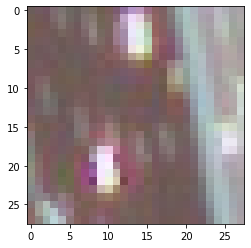

total indices:  4
[[11813, 11745, 20890, 10425]]
/Users/abhishekvaidyanathan/Downloads/geological_similarity/andesite/NCIP3.jpg


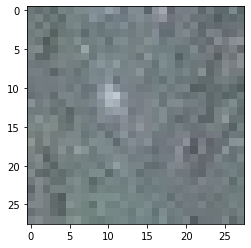

/Users/abhishekvaidyanathan/Downloads/geological_similarity/andesite/XORNT.jpg


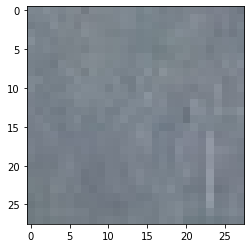

/Users/abhishekvaidyanathan/Downloads/geological_similarity/gneiss/6HU1R.jpg


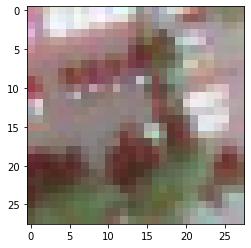

/Users/abhishekvaidyanathan/Downloads/geological_similarity/andesite/QSC9X.jpg


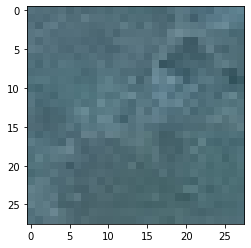

In [129]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
encoder = ConvEncoder()

# Load the state dict of encoder
encoder.load_state_dict(torch.load(ENCODER_MODEL_PATH, map_location=device))
encoder.eval()
encoder.to(device)

# Loads the embedding
embedding = np.load(EMBEDDING_PATH)
test_img = Image.open(TEST_IMAGE_PATH).convert("RGB")
plt.imshow(test_img)
plt.show()
indices_list,x = compute_similar_images(TEST_IMAGE_PATH, NUM_IMAGES, embedding, device)
plot_similar_images(indices_list)

In [105]:
embedding.shape

(29998, 576)

In [24]:
#trying out Principal Component Analysis
import numpy as np
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
results=pca.fit_transform(embedding)
print(results)


[[-2.806802   -3.0075257 ]
 [-7.1530347   0.21610254]
 [-3.515173   -2.1083107 ]
 ...
 [ 0.5316822   0.8761277 ]
 [ 1.4209647   3.0928488 ]
 [ 3.3972976  -1.1067998 ]]


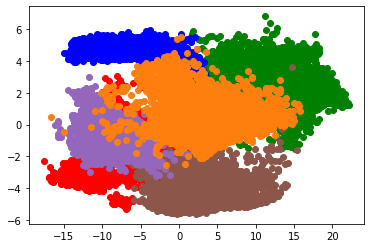

In [106]:
x= [i[0] for i in results]
y=[i[1] for i in results]
x_andesite=x[:5000]
y_andesite=y[:5000]
x_gneiss=x[5000:10000]
y_gneiss=y[5000:10000]
x_marble=x[10000:14998]
y_marble=y[10000:14998]
x_quartzite=x[14998:19998]
y_quartzite=y[14998:19998]
x_rhyolite=x[19998:24998]
y_rhyolite=y[19998:24998]
x_schist=x[24998:29998]
y_schist=y[24998:29998]
plt.scatter(x_andesite,y_andesite,c="r")
plt.scatter(x_gneiss,y_gneiss,c="g")
plt.scatter(x_marble,y_marble,c="b")
plt.scatter(x_quartzite,y_quartzite,c="#8c564b")
plt.scatter(x_rhyolite,y_rhyolite,c="#9467bd")
plt.scatter(x_schist,y_schist,c="#ff7f0e")
plt.show()

In [96]:
def write_to_file(test_img_path,indices_list,file_name):
    indices = indices_list[0]
    results=[]
    current_dir = {}
    for index in indices:
        img_path = image_paths[index]
        results.append(img_path)
    #results_string=' '.join(i for i in results)
    #print(results)
    with open(file_name, 'r', encoding='utf-8') as f:
        current_dir=json.load(f)
    current_dir[test_img_path]=indices
    # print(current_dir[test_img_path])
    with open(file_name, "w") as outfile:
        json.dump(current_dir, outfile)


In [97]:
testing_times=[]

In [98]:
def test_method(test_img_path,file_name):
    test_img = Image.open(test_img_path).convert("RGB")
    # plt.imshow(test_img)
    # plt.show()
    indices_list,time_taken = compute_similar_images(test_img_path, NUM_IMAGES, embedding, device)
    write_to_file(test_img_path,indices_list,file_name)
    #plot_similar_images(indices_list)
    testing_times.append(time_taken)
    return time_taken,indices_list

In [120]:
testing_images=[]
testing = pd.DataFrame({
        'testing_image': "dummy_data",
        'time_taken': 0,
        'indices_list': []
    })
for i in range(0,100):
    random_index=random.randint(0, len(image_paths)-1)
    testing_images.append(image_paths[random_index])

for i in range(len(testing_images)):
    time_taken,indices_list=test_method(testing_images[i],"hamming_knn_results.json")
    testing = testing.append(pd.DataFrame({
                'testing_image': testing_images[i],
                'time_taken': time_taken,
                'indices_list' : list(indices_list)
            }), ignore_index=True)
testing.to_csv("./hamming_knn_results.csv",index=False)
    # print(time_taken)

In [100]:
# dic={"Hello":"Wow"}
# with open("cosine_knn_results.json", "w") as outfile:
#     json.dump(dic, outfile)

In [55]:
avg_test_time=sum(testing_times)/len(testing_times)
print(avg_test_time)

0.05612516164779663


In [56]:
with open("jaccard_knn_results.json", 'r', encoding='utf-8') as f:
    content=json.load(f)
print(len(content.keys()))

200


In [57]:
textfile = open("timing_results/jaccard_knn_timings.txt", "w")
for i in range(len(testing_times)):

    textfile.write(str(testing_times[i])+"\n")

textfile.close()

### Next cell is to read the timings files

In [58]:
stored_times=[]
with open("timing_results/cosine_knn_timings.txt","r") as f:
    content=f.read()
stored_times=content.split('\n')
print(len(stored_times))

100


In [59]:
stored_times= [float(i) for i in stored_times]
sum(stored_times)/len(stored_times)

0.0992603874206543